In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dropout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from time import time

pitch = pd.read_excel("reduced_defensas.xlsx")

numeric_vars = ['Transfer_value', 'Exp_contr', 'Age', 'Minutes_pl', 'Minutes_pl_BC', 'NP_goals', 'Pen_goals', 'Pen_goals_BC', 'Assists', 'Interceptions', 'GCA_BC', 'Yellow_cards', 'Red_cards']
pitch[numeric_vars] = StandardScaler().fit_transform(pitch[numeric_vars])

In [4]:
ind_vars = ['Exp_contr', 'Age', 'Minutes_pl', 'Minutes_pl_BC',
       'NP_goals', 'Pen_goals', 'Pen_goals_BC', 'Assists', 'Interceptions',
       'GCA_BC', 'Yellow_cards', 'Red_cards', 'Reduced_team_from_Inter',
       'Reduced_team_from_AC Milan', 'Reduced_team_from_Juventus',
       'Reduced_team_from_Napoli', 'Reduced_team_from_Paris SG',
       'Reduced_team_from_Real Madrid', 'Reduced_team_from_Barcelona',
       'Reduced_team_from_Atlético Madrid', 'Reduced_team_from_Bayern Munich',
       'Reduced_team_from_Bor. Dortmund', 'Reduced_team_from_Chelsea',
       'Reduced_team_from_Arsenal', 'Reduced_team_from_Man City',
       'Reduced_team_from_Man Utd', 'Reduced_team_from_Liverpool', 'Reduced_country_from_Inglaterra',
       'Reduced_country_from_Francia', 'Reduced_country_from_España',
       'Reduced_country_from_Italia', 'Reduced_country_from_Alemania',
       'Reduced_country_from_Portugal', 'Reduced_country_from_Países Bajos',
       'Reduced_country_from_Argentina', 'Reduced_country_from_Brasil']

PermutationExplainer explainer: 1009it [03:19,  4.84it/s]                                                              
C:\Users\elias\AppData\Local\Temp\ipykernel_13172\3509062810.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X, feature_names = ind_vars)


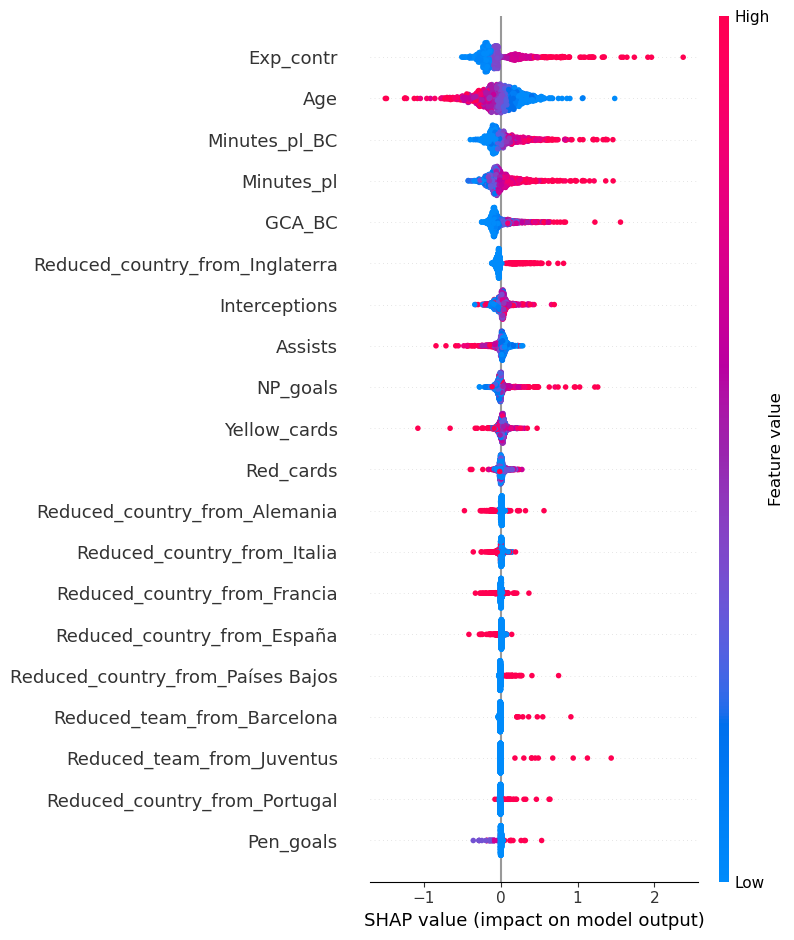

In [5]:
from tensorflow.keras.models import load_model

modelo_cargado = load_model("defensas_2.keras")
X = np.array(pitch[ind_vars])  # Asegúrate de usar las variables significativas

explainer = shap.Explainer(modelo_cargado, X)  # No necesitas un masker explícito aquí
shap_values = explainer(X)

# 0.1	2048.0	2048.0	1.0	relu	adam	mae	512.0	0.259066	0.367665	94.0	0.823773	0.257236
# Graficar el resumen SHAP
shap.summary_plot(shap_values, X, feature_names = ind_vars)

In [3]:
res = pd.DataFrame({
    'dropouts': [],
    'neurons_1': [],
    'neurons_2': [],
    'activations': [],
    'optimizers': [],
    'loss_function': [],
    'batchs': [],
    'loss': [],
    'val_loss': [],
    'Epochs': [],
    'R2': [],
    'MAE': []
})

In [4]:
time0 = time()

# 450 pruebas

dropouts = [0, 0.1, 0.2]
neurons_1 = [64, 128, 256, 512, 1024]
neurons_2 = [16, 32, 64, 128, 256, 512]
activations = ['relu']
optimizers = ['adam']
loss_f = ['mae']
batchs = [8, 16, 32, 64, 128]      
         
max_r2 = -10
for dropout in dropouts:
    for n1 in neurons_1:
        for n2 in neurons_2:
            for activation in activations:
                for optimizer in optimizers:
                    for loss in loss_f:
                        
                        print([dropout, n1, n2, activation, optimizer, loss])
                        print(time() - time0)
                            
                        for batch in batchs:  
                            
                            X = np.array(pitch[ind_vars])  # Asegúrate de usar las variables significativas
                            Y = pitch['Transfer_value']  # Variable dependiente

                            model = Sequential([
                                Dense(n1, activation=activation, input_shape=(X.shape[1],)),
                                Dropout(dropout),
                                Dense(n2, activation=activation),
                                Dropout(dropout),
                                Dense(1)
                            ])

                            model.compile(optimizer=optimizer, loss=loss)

                            early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

                            history = model.fit(X, Y, epochs=75, batch_size=batch, validation_split=0.2, callbacks=[early_stop], verbose=0);

                            y_pred = model.predict(X)

                
                            r2 = r2_score(Y, y_pred)

                            mae = mean_absolute_error(Y, y_pred)
                            
                            i = history.history['val_loss'].index(min(history.history['val_loss']))
                            l = history.history['loss'][i]
                            vl = history.history['val_loss'][i]
                            
                            nueva_fila = {'dropouts': dropout, 'neurons_1': n1, 'neurons_2': n2, 'activations': activation, 'optimizers': optimizer, 
                                          'loss_function': loss, 'batchs': batch, 'loss': l, 'val_loss': vl, 'Epochs': len(history.epoch), 'R2': r2, 'MAE': mae}
                            serie_nueva_fila = pd.Series(nueva_fila, name=len(res)) # El 'name' se convierte en el índice
                            res = pd.concat([res, pd.DataFrame([nueva_fila])], ignore_index=True)
                            
                            if r2 > max_r2:
                                best_model = model
                                max_r2 = r2

[0, 64, 16, 'relu', 'adam', 'mae']
0.0029959678649902344



32/32 [==============================] - 0s 2ms/step
[0, 64, 32, 'relu', 'adam', 'mae']
19.947479248046875
32/32 [==============================] - 0s 2ms/step
[0, 64, 64, 'relu', 'adam', 'mae']
36.43323087692261
32/32 [==============================] - 0s 2ms/step
[0, 64, 128, 'relu', 'adam', 'mae']
50.43812704086304
32/32 [==============================] - 0s 2ms/step
[0, 64, 256, 'relu', 'adam', 'mae']
62.9166259765625
32/32 [==============================] - 0s 1ms/step
[0, 64, 512, 'relu', 'adam', 'mae']
77.83941435813904
32/32 [==============================] - 0s 2ms/step
[0, 128, 16, 'relu', 'adam', 'mae']
94.37619757652283
32/32 [==============================] - 0s 2ms/step
[0, 128, 32, 'relu', 'adam', 'mae']
113.51959824562073
32/32 [==============================] - 0s 2ms/step
[0, 128, 64, 'relu', 'adam', 'mae']
129.39833164215088
32/32 [==============================] - 0s 1ms/step
[0, 128, 128, 'relu', 'adam', '

32/32 [==============================] - 0s 1ms/step
[0.1, 512, 64, 'relu', 'adam', 'mae']
929.0422623157501
32/32 [==============================] - 0s 2ms/step
[0.1, 512, 128, 'relu', 'adam', 'mae']
946.2345747947693
32/32 [==============================] - 0s 2ms/step
[0.1, 512, 256, 'relu', 'adam', 'mae']
965.074068069458
32/32 [==============================] - 0s 2ms/step
[0.1, 512, 512, 'relu', 'adam', 'mae']
982.6723420619965
32/32 [==============================] - 0s 2ms/step
[0.1, 1024, 16, 'relu', 'adam', 'mae']
1013.7334442138672
32/32 [==============================] - 0s 2ms/step
[0.1, 1024, 32, 'relu', 'adam', 'mae']
1029.6553654670715
32/32 [==============================] - 0s 2ms/step
[0.1, 1024, 64, 'relu', 'adam', 'mae']
1049.5652627944946
32/32 [==============================] - 0s 2ms/step
[0.1, 1024, 128, 'relu', 'adam', 'mae']
1078.102068901062
32/32 [==============================] - 0s 3ms/step
[0.1, 1024, 256, 'relu', 'adam', 'mae']
1101.8538937568665
32/32 

In [5]:
res.sort_values(by='R2', ascending=False)

,dropouts,neurons_1,neurons_2,activations,optimizers,loss_function,batchs,loss,val_loss,Epochs,R2,MAE
265,0.1,512.0,512.0,relu,adam,mae,8.0,0.196465,0.362346,32.0,0.846066,0.213519
220,0.1,256.0,64.0,relu,adam,mae,8.0,0.229140,0.358880,33.0,0.814963,0.231578
140,0.0,1024.0,256.0,relu,adam,mae,8.0,0.216856,0.373646,25.0,0.812386,0.228955
141,0.0,1024.0,256.0,relu,adam,mae,16.0,0.238608,0.365224,21.0,0.797130,0.241416
282,0.1,1024.0,64.0,relu,adam,mae,32.0,0.233712,0.372651,28.0,0.796578,0.235352
...,...,...,...,...,...,...,...,...,...,...,...,...
4,0.0,64.0,16.0,relu,adam,mae,128.0,0.324161,0.418457,38.0,0.519423,0.340576
19,0.0,64.0,128.0,relu,adam,mae,128.0,0.342575,0.408136,23.0,0.517839,0.356805
184,0.1,128.0,16.0,relu,adam,mae,128.0,0.397507,0.384962,22.0,0.515500,0.361252
330,0.2,128.0,16.0,relu,adam,mae,8.0,0.411392,0.388129,11.0,0.512168,0.360303


In [6]:
from tensorflow.keras.models import load_model

# Cargar el modelo
modelo_cargado = load_model("defensas_2.keras")

# best_model.save("defensas_2.keras")

# 0.1	512.0	512.0	relu	adam	mae	8.0	0.196465	0.362346	32.0	0.846066	0.213519

In [3]:
res_2 = pd.DataFrame({
    'dropouts': [],
    'neurons_1': [],
    'neurons_2': [],
    'neurons_3': [],
    'activations': [],
    'optimizers': [],
    'loss_function': [],
    'batchs': [],
    'loss': [],
    'val_loss': [],
    'Epochs': [],
    'R2': [],
    'MAE': []
})

In [5]:
time0 = time()

# 1323 pruebas

dropouts = [0, 0.1]  # 0.1, 0.2, 0.3, 0.4
neurons_1 = [16, 32, 64, 128, 256, 512, 1024]
neurons_2 = [8, 16, 32, 64, 128, 256, 512]
neurons_3 = [2, 3, 4]
activations = ['relu']
optimizers = ['adam']
loss_f = ['mae']
batchs = [8, 16, 32]      

max_r2 = -10
for dropout in dropouts:
    for n1 in neurons_1:
        for n2 in neurons_2:
            for n3 in neurons_3:
                print([dropout, n1, n2, n3])
                print(time() - time0)
                for activation in activations:
                    for optimizer in optimizers:
                        for loss in loss_f:                            
                            for batch in batchs:  

                                X = np.array(pitch[ind_vars])  # Asegúrate de usar las variables significativas
                                Y = pitch['Transfer_value']  # Variable dependiente

                                model = Sequential([
                                    Dense(n1, activation=activation, input_shape=(X.shape[1],)),
                                    Dropout(dropout),
                                    Dense(n2, activation=activation),
                                    Dropout(dropout),
                                    Dense(n3, activation=activation),
                                    Dropout(dropout),
                                    Dense(1)
                                ])

                                model.compile(optimizer=optimizer, loss=loss)

                                early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)

                                history = model.fit(X, Y, epochs=75, batch_size=batch, validation_split=0.2, callbacks=[early_stop], verbose=0);

                                y_pred = model.predict(X, verbose=0)


                                r2 = r2_score(Y, y_pred)

                                mae = mean_absolute_error(Y, y_pred)

                                i = history.history['val_loss'].index(min(history.history['val_loss']))
                                l = history.history['loss'][i]
                                vl = history.history['val_loss'][i]

                                nueva_fila = {'dropouts': dropout, 'neurons_1': n1, 'neurons_2': n2, 'neurons_3': n3, 'activations': activation, 'optimizers': optimizer, 
                                              'loss_function': loss, 'batchs': batch, 'loss': l, 'val_loss': vl, 'Epochs': len(history.epoch), 'R2': r2, 'MAE': mae}
                                serie_nueva_fila = pd.Series(nueva_fila, name=len(res_2)) # El 'name' se convierte en el índice
                                res_2 = pd.concat([res_2, pd.DataFrame([nueva_fila])], ignore_index=True)    
                                
                                if r2 > max_r2:
                                    best_model = model
                                    max_r2 = r2

[0, 16, 8, 2]
0.0
[0, 16, 8, 3]
14.813595056533813
[0, 16, 8, 4]
31.726957082748413
[0, 16, 16, 2]
50.498046875
[0, 16, 16, 3]
66.00809073448181
[0, 16, 16, 4]
81.71494245529175
[0, 16, 32, 2]
97.71595811843872
[0, 16, 32, 3]
110.86001229286194
[0, 16, 32, 4]
130.55521631240845
[0, 16, 64, 2]
146.72154188156128
[0, 16, 64, 3]
162.67340469360352
[0, 16, 64, 4]
177.27747011184692
[0, 16, 128, 2]
191.4048991203308
[0, 16, 128, 3]
210.1355104446411
[0, 16, 128, 4]
225.11278796195984
[0, 16, 256, 2]
239.3024160861969
[0, 16, 256, 3]
259.0218617916107
[0, 16, 256, 4]
277.7948877811432
[0, 16, 512, 2]
290.33552289009094
[0, 16, 512, 3]
307.56121349334717
[0, 16, 512, 4]
321.5181622505188
[0, 32, 8, 2]
335.3709363937378
[0, 32, 8, 3]
357.8340640068054
[0, 32, 8, 4]
381.43955087661743
[0, 32, 16, 2]
403.77931904792786
[0, 32, 16, 3]
427.27243638038635
[0, 32, 16, 4]
441.6595067977905
[0, 32, 32, 2]
460.14810943603516
[0, 32, 32, 3]
479.33104968070984
[0, 32, 32, 4]
496.9624729156494
[0, 32, 64,

[0.1, 256, 16, 3]
4492.218298435211
[0.1, 256, 16, 4]
4506.4158499240875
[0.1, 256, 32, 2]
4522.529014110565
[0.1, 256, 32, 3]
4536.642286777496
[0.1, 256, 32, 4]
4551.810745954514
[0.1, 256, 64, 2]
4568.562713623047
[0.1, 256, 64, 3]
4586.841064214706
[0.1, 256, 64, 4]
4602.000872135162
[0.1, 256, 128, 2]
4621.246424913406
[0.1, 256, 128, 3]
4633.972034692764
[0.1, 256, 128, 4]
4648.643936634064
[0.1, 256, 256, 2]
4661.80520772934
[0.1, 256, 256, 3]
4679.401440620422
[0.1, 256, 256, 4]
4692.516736030579
[0.1, 256, 512, 2]
4707.988401412964
[0.1, 256, 512, 3]
4725.24137711525
[0.1, 256, 512, 4]
4744.635922431946
[0.1, 512, 8, 2]
4760.744671583176
[0.1, 512, 8, 3]
4773.345052480698
[0.1, 512, 8, 4]
4791.540166854858
[0.1, 512, 16, 2]
4809.238708019257
[0.1, 512, 16, 3]
4822.037519454956
[0.1, 512, 16, 4]
4841.472851514816
[0.1, 512, 32, 2]
4854.882870674133
[0.1, 512, 32, 3]
4872.054920434952
[0.1, 512, 32, 4]
4886.207602977753
[0.1, 512, 64, 2]
4902.206760644913
[0.1, 512, 64, 3]
4917.

In [6]:
res_2.sort_values(by='R2', ascending=False)

,dropouts,neurons_1,neurons_2,neurons_3,activations,optimizers,loss_function,batchs,loss,val_loss,Epochs,R2,MAE
238,0.0,128.0,128.0,3.0,relu,adam,mae,16.0,0.201764,0.354545,29.0,0.807485,0.225670
335,0.0,512.0,16.0,2.0,relu,adam,mae,32.0,0.234532,0.380510,41.0,0.800051,0.241400
249,0.0,128.0,256.0,4.0,relu,adam,mae,8.0,0.240806,0.378226,21.0,0.796546,0.236548
280,0.0,256.0,32.0,2.0,relu,adam,mae,16.0,0.223069,0.388152,37.0,0.795804,0.246575
364,0.0,512.0,128.0,3.0,relu,adam,mae,16.0,0.234797,0.375034,25.0,0.775193,0.241666
...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,0.0,1024.0,512.0,2.0,relu,adam,mae,8.0,0.557240,0.548595,11.0,-0.110894,0.553523
378,0.0,512.0,512.0,2.0,relu,adam,mae,8.0,0.557180,0.548604,11.0,-0.111511,0.553426
873,0.1,1024.0,256.0,2.0,relu,adam,mae,8.0,0.556748,0.548606,11.0,-0.111633,0.553406
369,0.0,512.0,256.0,2.0,relu,adam,mae,8.0,0.556877,0.548630,11.0,-0.113262,0.553154


In [7]:
# best_model.save("defensas_3.keras")

# 0.0	128.0	128.0	3.0	relu	adam	mae	16.0	0.201764	0.354545	29.0	0.807485	0.225670

In [8]:
from tensorflow.keras.models import load_model

modelo_cargado = load_model("defensas_3.keras")
y_pred = modelo_cargado.predict(X, verbose=0)

r2 = r2_score(Y, y_pred)
mae = mean_absolute_error(Y, y_pred)

print(r2, mae)

0.8074848458204485 0.2256702516519364
